In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def conv(s):
    if s == '':
        return np.nan
    return np.float64(s.replace(',', '.'))

In [3]:
train_data = pd.read_csv('./init/1/train_1.8.csv', encoding='cp1251', converters={'Нефть, т' : conv,
                                                                           'Попутный газ, м3' : conv,
                                                                           'Нефть, м3' : conv,
                                                                           'Время работы, ч' : conv})
test_data = pd.read_csv('./init/1/test_1.9.csv', encoding='cp1251', converters={'Попутный газ, м3' : conv})

In [4]:
train_wells = np.unique(train_data[train_data['Характер работы'] == 'НЕФ']['Скважина'])
test_wells = np.unique(test_data['Скважина'])

In [5]:
feats = ['Скважина', 'Характер работы', 'Дата', 'Нефть, т', 'Попутный газ, м3', 'Время работы, ч', 'Нефть, м3', 'Дебит жидкости', 'Обводненность']

In [6]:
new_df = []

for well in train_wells:
    cur_df = train_data[train_data['Скважина'] == well][feats].sort_values('Дата')
    if cur_df['Нефть, т'].iloc[0] != '0.00':
        cur_df = cur_df.iloc[0]
    elif cur_df['Нефть, т'].iloc[1] != '0.00':
        cur_df = cur_df.iloc[1]
    elif cur_df['Нефть, т'].iloc[2] != '0.00':
        cur_df = cur_df.iloc[2]
    elif cur_df['Нефть, т'].iloc[3] != '0.00':
        cur_df = cur_df.iloc[3]
    else:
        cur_df = cur_df.iloc[4]
    
    new_df.append(cur_df)

In [7]:
new_df = pd.concat(new_df, axis=1).T

In [8]:
new_df['Дебит'] = new_df['Дебит жидкости'] - new_df['Обводненность'] * new_df['Дебит жидкости'] / 100

In [9]:
new_df['Дебит2'] = new_df['Нефть, м3'] / (new_df['Время работы, ч'] / 24)

In [10]:
new_df['Дебит'] = new_df['Дебит'].fillna(new_df['Дебит2'])

In [11]:
debit_train = new_df[['Скважина', 'Нефть, т', 'Время работы, ч', 'Дебит', 'Попутный газ, м3']].dropna(0)

In [12]:
debit_train.head()

,Скважина,"Нефть, т","Время работы, ч",Дебит,"Попутный газ, м3"
1570,005642f48d3e86d871bb701bac2ba042,462,432,29.722222,29568
768,02bd0350b7f0cef7af7ca50801d89810,15.32,24,18.270000,2148
1600,038753062b1b3941bbce024a2af27e18,553,216,71.111111,35392
1816,04154a658a396d1c18331ebf0330744f,46,80,15.600000,3166
42,04d7884a9f7019671285b87ca468d0f1,334,310,29.729032,11718


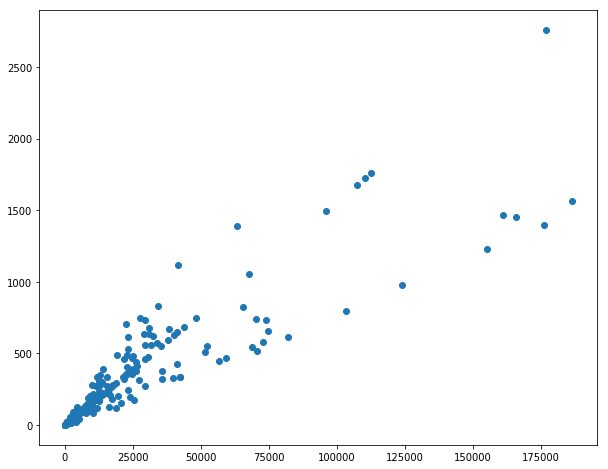

In [13]:
x = debit_train['Попутный газ, м3'].values.astype(np.float64)[:, np.newaxis]
y = debit_train['Нефть, т'].values.astype(np.float64)[:, np.newaxis]
angle = y / (x + 1)

plt.figure(figsize=(10, 8))
plt.scatter(x, y)
#plt.xlim(0, 300000)

In [14]:
xy = angle #np.hstack([x, y, angle])

In [15]:
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN

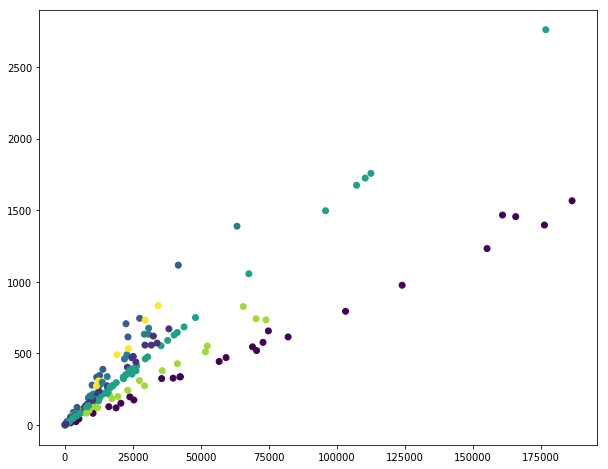

In [16]:
kmeans = KMeans(n_clusters = 8, random_state=1543)


labels = kmeans.fit_predict(xy)[:, None]

plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=labels)

In [17]:
z = debit_train['Время работы, ч'].values.astype(np.float64)[:, np.newaxis]

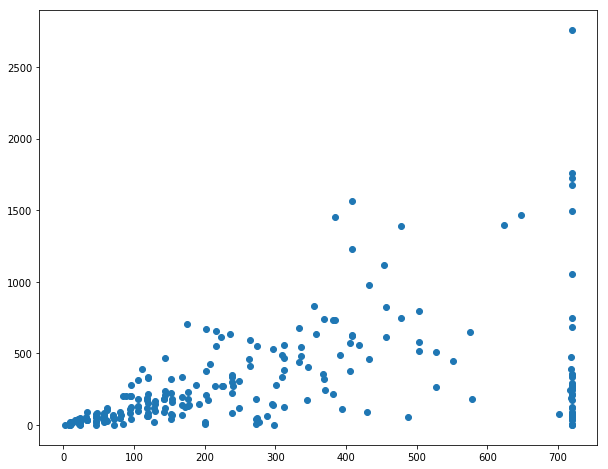

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(z, y)

In [19]:
mean_angle = angle.mean()

## Достанем данные по координатам

In [20]:
coords_train = pd.read_csv('./init/1/coords_train_1.1.csv', encoding='cp1251')
coords_train = coords_train.groupby('well_hash')['ПЛАСТ_X', 'ПЛАСТ_Y'].mean()
coords_train.reset_index(inplace=True)
coords_train.rename(columns={'well_hash' : 'Скважина'}, inplace=True)

In [21]:
coords_test = pd.read_csv('./init/1/coords_test_1.1.csv', encoding='cp1251')
coords_test = coords_test.groupby('well_hash')['ПЛАСТ_X', 'ПЛАСТ_Y'].mean()
coords_test.reset_index(inplace=True)
coords_test.rename(columns={'well_hash' : 'Скважина'}, inplace=True)

In [22]:
coords_train.head()

,Скважина,ПЛАСТ_X,ПЛАСТ_Y
0,02bd0350b7f0cef7af7ca50801d89810,1.297986e+07,3.998130e+07
1,046568c4bd1c6343c5f932ef6a21b112,1.243139e+07,3.780028e+07
2,04d7884a9f7019671285b87ca468d0f1,1.243339e+07,3.781346e+07
3,053c7b37c95c4617f331791134227db7,1.240853e+07,3.776296e+07
4,0556368a803a0c64972646d4bfaecd86,1.164759e+07,3.637853e+07


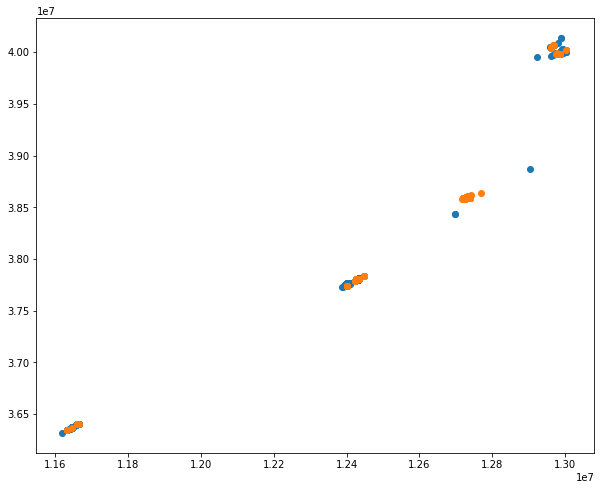

In [23]:
x_train = coords_train['ПЛАСТ_X'].values
y_train = coords_train['ПЛАСТ_Y'].values

x_test = coords_test['ПЛАСТ_X'].values
y_test = coords_test['ПЛАСТ_Y'].values

plt.figure(figsize=(10, 8))
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test)

## Достанем данные по давлению в пласте

In [24]:
gdis_train = pd.read_csv('./init/1/gdis_train1.2.csv', encoding='cp1251')
gdis_train = gdis_train.groupby('Скважина').mean().reset_index()

gdis_test = pd.read_csv('./init/1/gdis_test1.2.csv', encoding='cp1251')
gdis_test = gdis_test.groupby('Скважина').mean().reset_index()

In [25]:
gdis_train.head()

,Скважина,Давление пластовое
0,005642f48d3e86d871bb701bac2ba042,103.150000
1,02384c4d1324238fb99fcf66c88fbdad,218.566667
2,02bd0350b7f0cef7af7ca50801d89810,255.150000
3,031f7cf95ada8d6e49ad6bd96c886d9c,83.000000
4,038753062b1b3941bbce024a2af27e18,232.300000


## Достанем данные по ГРП

In [26]:
grp_df_train = pd.read_csv('./init/1/frac_train_1.csv', encoding='cp1251')

In [27]:
grp_train = pd.Series(train_wells).apply(lambda x: x in grp_df_train['Скважина'].values).astype(int)

In [28]:
grp_train = pd.DataFrame(data=np.stack([train_wells, grp_train], axis=1), columns=['Скважина', 'ГРП'])

In [29]:
grp_train.head()

,Скважина,ГРП
0,005642f48d3e86d871bb701bac2ba042,1
1,02384c4d1324238fb99fcf66c88fbdad,1
2,02bd0350b7f0cef7af7ca50801d89810,1
3,02dba139f57f4aa50c3fbf56f586551f,1
4,038753062b1b3941bbce024a2af27e18,1


In [30]:
grp_df_test = pd.read_csv('./init/1/frac_test_1.csv', encoding='cp1251')

In [31]:
grp_test = pd.Series(test_wells).apply(lambda x: x in grp_df_test['Скважина'].values).astype(int)

In [32]:
grp_test = pd.DataFrame(data=np.stack([test_wells, grp_test], axis=1), columns=['Скважина', 'ГРП'])

In [33]:
grp_test.head()

,Скважина,ГРП
0,002ff5b8a6dc271f58581e1b4fa2c5fc,1
1,008d0347e572a5d938a9c40c29e539fc,0
2,00b40cb7bb8c9fd1ac26b4cc86f2b291,0
3,01ba18d8b6d29875a18d4bca4eb201d7,1
4,024ec6f6e3f9c5150ecf525bf8b7a6a3,1


## Объединим все!

In [34]:
all_train = pd.concat([debit_train.set_index('Скважина'),
                       grp_train.set_index('Скважина'),
                       gdis_train.set_index('Скважина'),
                       coords_train.set_index('Скважина')], axis=1)

all_test = pd.concat([test_data[['Скважина', 'Попутный газ, м3']].set_index('Скважина'),
                      grp_test.set_index('Скважина'),
                      gdis_test.set_index('Скважина'),
                      coords_test.set_index('Скважина')], axis=1)

In [35]:
all_train = all_train.fillna({'Давление пластовое' : all_train['Давление пластовое'].mean(), 
                              'ПЛАСТ_X':-9999, 
                              'ПЛАСТ_Y':-9999})
all_test = all_test.fillna({'Давление пластовое' : all_train['Давление пластовое'].mean(), 
                            'ПЛАСТ_X':-9999, 
                            'ПЛАСТ_Y':-9999})

In [36]:
all_test.head()

,"Попутный газ, м3",ГРП,Давление пластовое,ПЛАСТ_X,ПЛАСТ_Y
002ff5b8a6dc271f58581e1b4fa2c5fc,0.0,1,185.958466,-9.999000e+03,-9.999000e+03
008d0347e572a5d938a9c40c29e539fc,NaN,0,185.958466,1.272636e+07,3.857880e+07
00b40cb7bb8c9fd1ac26b4cc86f2b291,NaN,0,185.958466,-9.999000e+03,-9.999000e+03
01ba18d8b6d29875a18d4bca4eb201d7,6929.0,1,117.500000,-9.999000e+03,-9.999000e+03
024ec6f6e3f9c5150ecf525bf8b7a6a3,0.0,1,231.000000,1.243423e+07,3.781085e+07


In [37]:
all_train.head()

,"Нефть, т","Время работы, ч",Дебит,"Попутный газ, м3",ГРП,Давление пластовое,ПЛАСТ_X,ПЛАСТ_Y
005642f48d3e86d871bb701bac2ba042,462,432,29.722222,29568,1,103.150000,-9.999000e+03,-9.999000e+03
02384c4d1324238fb99fcf66c88fbdad,NaN,NaN,NaN,NaN,1,218.566667,-9.999000e+03,-9.999000e+03
02bd0350b7f0cef7af7ca50801d89810,15.32,24,18.270000,2148,1,255.150000,1.297986e+07,3.998130e+07
02dba139f57f4aa50c3fbf56f586551f,NaN,NaN,NaN,NaN,1,185.958466,-9.999000e+03,-9.999000e+03
031f7cf95ada8d6e49ad6bd96c886d9c,NaN,NaN,NaN,NaN,NaN,83.000000,-9.999000e+03,-9.999000e+03


## Отделим данные с попутным газом и без него

In [38]:
gas_index = all_test['Попутный газ, м3'] > 0

In [39]:
starting_oil_pred = np.zeros(all_test.shape[0]) 
starting_oil_pred[gas_index] = mean_angle * all_test['Попутный газ, м3'][gas_index]

# Предсказание стартового значения "Нефть, т"

In [40]:
X = pd.DataFrame(all_train[['Нефть, т', 'ГРП', 'Давление пластовое', 'ПЛАСТ_X', 'ПЛАСТ_Y']]).dropna(0)
y = X['Нефть, т']
X = X.drop('Нефть, т', 1)
X_test = pd.DataFrame(all_test[['ГРП', 'Давление пластовое', 'ПЛАСТ_X', 'ПЛАСТ_Y']])[~gas_index]

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1543)

#### KNN

In [43]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import make_scorer

In [44]:
kfold = KFold(n_splits=5)
grid = GridSearchCV(KNeighborsRegressor(),
                    param_grid={'n_neighbors' : np.arange(1, 100, 3), 
                                'p' : [1, 2, 3, 4]},
                    scoring='neg_mean_absolute_error',
                    cv=kfold)

In [45]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49,
       52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 97]), 'p': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [46]:
grid.best_score_

-237.37053947808633

In [47]:
grid.best_params_

{'n_neighbors': 49, 'p': 1}

In [48]:
knn = grid.best_estimator_
knn.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=49, p=1,
          weights='uniform')

In [49]:
starting_oil_pred[~gas_index] = knn.predict(X_test)

In [50]:
starting_oil_df = pd.DataFrame(data={'starting_oil' : starting_oil_pred}, index=all_test.index)

In [51]:
starting_oil_df.head()

,starting_oil
002ff5b8a6dc271f58581e1b4fa2c5fc,207.461837
008d0347e572a5d938a9c40c29e539fc,267.507143
00b40cb7bb8c9fd1ac26b4cc86f2b291,207.461837
01ba18d8b6d29875a18d4bca4eb201d7,109.233242
024ec6f6e3f9c5150ecf525bf8b7a6a3,311.273265


In [53]:
starting_oil_df.to_csv('./starting_oil.csv')